In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchmetrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pickle

In [3]:
SESSION = 'MNIST2'

LOAD_INDICES=False
LOAD_MODELS=False
LOAD_INFORMATIONS=False

SESSIONS_PATH = 'sessions/'

In [4]:
session_path = os.path.join(SESSIONS_PATH, SESSION)
indices_path = os.path.join(session_path, f'{SESSION}_indices.pkl')
trained_model_path = os.path.join(session_path, f'{SESSION}_trained.pt')
benchmark_model_path = os.path.join(session_path, f'{SESSION}_benchmark.pt')
informations_path = os.path.join(session_path, f'{SESSION}_informations.pkl')

if not os.path.exists(SESSIONS_PATH):
    os.makedirs(SESSIONS_PATH)

if not os.path.exists(session_path):
    os.makedirs(session_path)

if LOAD_INDICES and not os.path.exists(indices_path):
    raise FileNotFoundError(f"Indices file not found at {indices_path}.")
if not LOAD_INDICES and os.path.exists(indices_path):
    raise FileExistsError(f"Indices file already exists at {indices_path}.")
if LOAD_MODELS and not os.path.exists(trained_model_path):
    raise FileNotFoundError(f"Trained model file not found at {trained_model_path}.")
if not LOAD_MODELS and os.path.exists(trained_model_path):
    raise FileExistsError(f"Trained model file already exists at {trained_model_path}.")
if LOAD_MODELS and not os.path.exists(benchmark_model_path):
    raise FileNotFoundError(f"Benchmark model file not found at {benchmark_model_path}.")
if not LOAD_MODELS and os.path.exists(benchmark_model_path):
    raise FileExistsError(f"Benchmark model file already exists at {benchmark_model_path}.")
if LOAD_INFORMATIONS and not os.path.exists(informations_path):
    raise FileNotFoundError(f"Informations file not found at {informations_path}.")
if not LOAD_INFORMATIONS and os.path.exists(informations_path):
    raise FileExistsError(f"Informations file already exists at {informations_path}.")

In [5]:
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Print number of samples in the dataset
print(f"Number of samples in the dataset: {len(dataset)}")

Number of samples in the dataset: 60000


In [ ]:
from fisherunlearn.clients_utils import split_dataset_by_class_distribution

# Compute the number of classes
num_classes = len(dataset.classes)

num_clients = 5
target_client = 0

if LOAD_INDICES:
    # Load the indices from the file
    with open(indices_path, 'rb') as f:
        client_indices = pickle.load(f)

    # Create subsets based on the loaded indices
    client_subsets = [torch.utils.data.Subset(dataset, indices) for indices in client_indices]

    
else:
    # Create subsets

    # Unique class distribution
    # client_distributions =  np.zeros((num_clients, num_classes))
    # for i in range(num_clients):
    #     for j in range(5):
    #         client_distributions[i][j] = 1/10
    #     client_distributions[i][5+i] = 1/2

    # Dirichlet distribution
    client_distributions = np.random.dirichlet(np.repeat(1, num_classes), num_clients)

    # Uniform distribution
    #client_distributions = np.ones((num_clients, num_classes)) / num_classes

    client_subsets = split_dataset_by_class_distribution(dataset, client_distributions)

    # Random split
    #client_subsets = torch.utils.data.random_split(dataset, [1 / num_clients] * num_clients)

    client_indices = [subset.indices for subset in client_subsets]

    # Save the indices to a file
    with open(indices_path, 'wb') as f:
        pickle.dump(indices_path, f)


classes_distributions = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    classes_distributions[i][i] = 1
    
classes_subsets = split_dataset_by_class_distribution(dataset, classes_distributions)

for subset in client_subsets:
    print(f"Number of samples in the subset: {len(subset)}")

# Create dataloaders
client_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets]

benchmark_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets]
benchmark_dataloaders.pop(target_client)
target_dataloader = DataLoader(client_subsets[target_client], batch_size=64, shuffle=True)

classes_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=False) for subset in classes_subsets]
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Number of samples in the subset: 12000
Number of samples in the subset: 12000
Number of samples in the subset: 12000
Number of samples in the subset: 12000
Number of samples in the subset: 12000


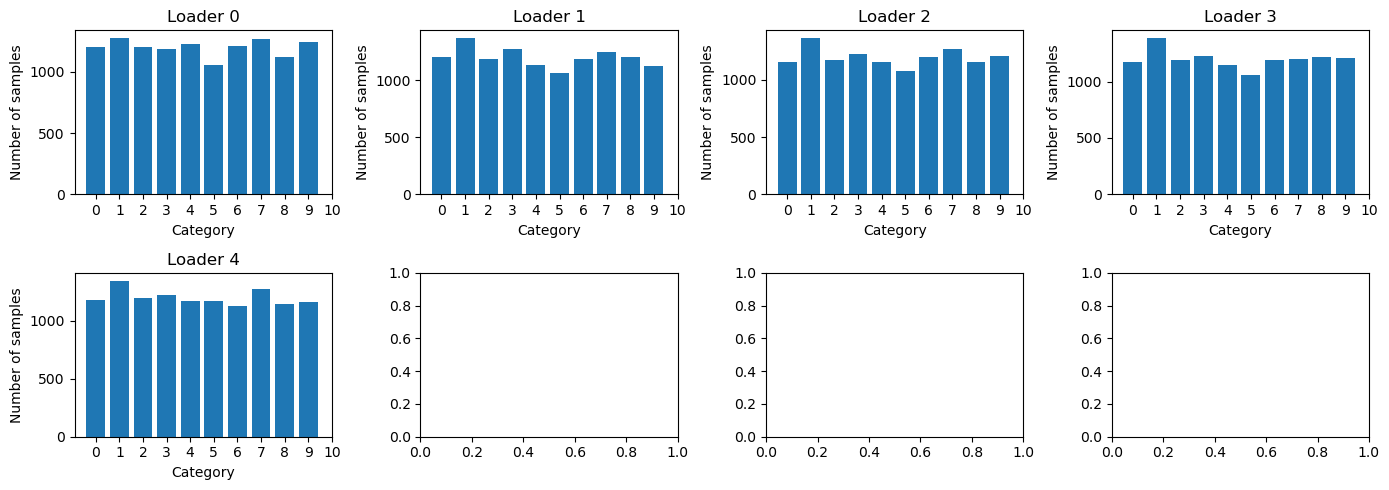

Total samples for class 0: 5923
Total samples for class 1: 6742
Total samples for class 2: 5958
Total samples for class 3: 6131
Total samples for class 4: 5842
Total samples for class 5: 5421
Total samples for class 6: 5918
Total samples for class 7: 6265
Total samples for class 8: 5851
Total samples for class 9: 5949


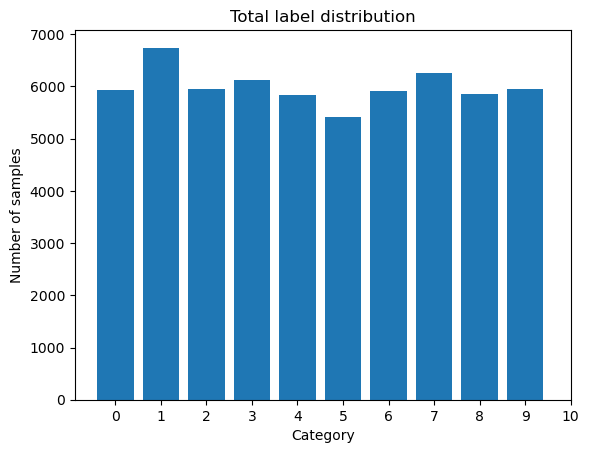

In [ ]:
from collections import Counter

def get_label_distribution(dataloader):
    label_counts = Counter()
    for _, labels in dataloader:
        label_counts.update(labels.tolist())
    return dict(label_counts)

# Choose dataloader list to visualize
dataloaders = client_dataloaders
num_classes_vis = num_classes

width = np.ceil(np.sqrt(2*len(dataloaders))).astype(int)
height = np.ceil(width/2).astype(int)

axs = fig, axs = plt.subplots(height, width, figsize=(14, 5))
label_distributions = []
for i, loader in enumerate(dataloaders):
    label_distribution = get_label_distribution(loader)
    label_distributions.append(label_distribution)
    axs[i//width][i%width].bar(label_distribution.keys(), label_distribution.values())
    axs[i//width][i%width].set_title(f'Loader {i}')
    axs[i//width][i%width].set_xlabel('Category')
    axs[i//width][i%width].set_xticks(range(num_classes_vis+1))
    axs[i//width][i%width].set_ylabel('Number of samples')

plt.tight_layout()
plt.show()

total_label_distribution = {}
for key in range(num_classes_vis):
    total_label_distribution[key] = 0
    for distribution in label_distributions:
        if key in distribution:
            total_label_distribution[key] += distribution[key]

plt.bar(total_label_distribution.keys(), total_label_distribution.values())
plt.title('Total label distribution')
plt.xlabel('Category')
plt.xticks(range(num_classes_vis+1))
plt.ylabel('Number of samples')
plt.show()

In [ ]:
class FLNet(nn.Sequential):
    def __init__(self):
        super(FLNet, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

test_model = FLNet()
model_parameters = filter(lambda p: p.requires_grad, test_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the model: {params}")

Number of parameters in the model: 1663370


In [ ]:
def compute_accuracy(model, dataloader, device=None):
    if device is None:
        device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device_ = device
        
    model.to(device_)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device_), labels.to(device_)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device is None:
        model.cpu()

    return correct / total

def compute_dataloaders_accuracy(model, dataloaders):
    accuracies = []
    for idx, dataloader in enumerate(dataloaders):
        accuracy = compute_accuracy(model, dataloader)
        accuracies.append(accuracy)
    return accuracies

# create validation routine
def validate(model, dataloaders, num_classes, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    # create metric objects
    tm_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average= 'macro', top_k=1)
    tm_con = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes)
    # move metric to device
    model.to(device)
    tm_acc.to(device)
    tm_con.to(device)
    # set network in eval mode
    model.eval()
    # at the end of epoch, validate model
    for loader_idx, loader in enumerate(dataloaders):
        for inputs, targets in loader:
        
            inputs = inputs.to(device)
            targets = targets.to(device)
            # remove singleton dimension
            targets = targets.squeeze()
            # get output
            with torch.no_grad():
                # perform prediction
                logits = model(inputs)
            # update metrics
            _, predicted = torch.max(logits.data, 1)
            tm_acc.update(predicted, targets)
            tm_con.update(predicted, targets)

    # at the end, compute metric
    acc = tm_acc.compute()
    con = tm_con.compute()
    # set network in training mode
    
    return acc, con


def plot_confusion_matrix(conf_mat):
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(conf_mat.cpu())
    x=x.style.background_gradient(cmap=cm)
    display(x)

In [ ]:
def trainer(model, loss_fn, client_dataloaders, epochs):
    torch.cuda.empty_cache()
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    #device = "cpu"
    model.to(device)

    for epoch in range(epochs):
        for client_loader in client_dataloaders:
            for imgs, labels in client_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs)
                loss = loss_fn(preds, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
        # Evaluate on test set
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
        
    return model

# Save the model
def save_model_with_unique_name(model, base_path):
    # Split the base_path into the file name and extension
    base, ext = os.path.splitext(base_path)
    new_path = base_path
    counter = 1
    
    # Check if the file exists and update the filename if needed
    while os.path.exists(new_path):
        new_path = f"{base}({counter}){ext}"
        counter += 1

    torch.save(model.state_dict(), new_path)
    print(f"Model saved to {new_path}")

In [ ]:
# Model
model = FLNet()
model_benchmark = FLNet()
loss_fn = nn.CrossEntropyLoss()

if not LOAD_MODELS:
    assert not os.path.exists(trained_model_path), f"Model already exists at {trained_model_path}."
    assert not os.path.exists(benchmark_model_path), f"Model already exists at {benchmark_model_path}."

    model=trainer(model, loss_fn, client_dataloaders, epochs=10)
    torch.save(model.state_dict(), trained_model_path)
    model_benchmark=trainer(model_benchmark, loss_fn, benchmark_dataloaders, epochs=10)
    torch.save(model_benchmark.state_dict(), benchmark_model_path)

else:
    model.load_state_dict(torch.load(trained_model_path, weights_only=True))
    model_benchmark.load_state_dict(torch.load(benchmark_model_path, weights_only=True))

cuda
Epoch 1/10, Loss: 0.0523
Epoch 2/10, Loss: 0.0043
Epoch 3/10, Loss: 0.0065
Epoch 4/10, Loss: 0.0514
Epoch 5/10, Loss: 0.0258
Epoch 6/10, Loss: 0.0009
Epoch 7/10, Loss: 0.0091
Epoch 8/10, Loss: 0.0017
Epoch 9/10, Loss: 0.0031
Epoch 10/10, Loss: 0.0000
cuda
Epoch 1/10, Loss: 0.0261
Epoch 2/10, Loss: 0.0103
Epoch 3/10, Loss: 0.0015
Epoch 4/10, Loss: 0.0030
Epoch 5/10, Loss: 0.0098
Epoch 6/10, Loss: 0.0217
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0012
Epoch 9/10, Loss: 0.0002
Epoch 10/10, Loss: 0.0036


In [ ]:
from fisherunlearn import compute_informations

if not LOAD_INFORMATIONS:
    assert not os.path.exists(informations_path), f"Informations already exists at {informations_path}."
    
    informations = compute_informations(model, loss_fn, client_dataloaders, use_converter=True)

    with open(informations_path, 'wb') as f:
            pickle.dump(informations, f)
else:
    with open(informations_path, 'rb') as f:
        informations = pickle.load(f)

Computing clients information: 100%|██████████| 940/940 [00:43<00:00, 21.75batch/s]


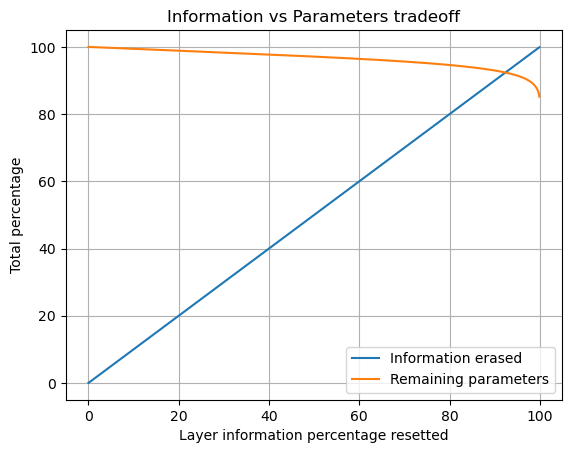

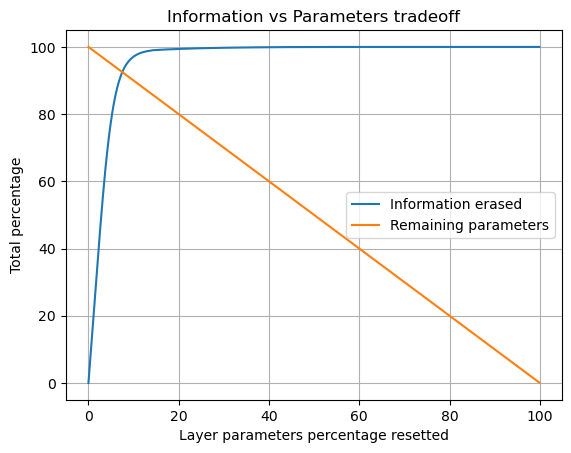

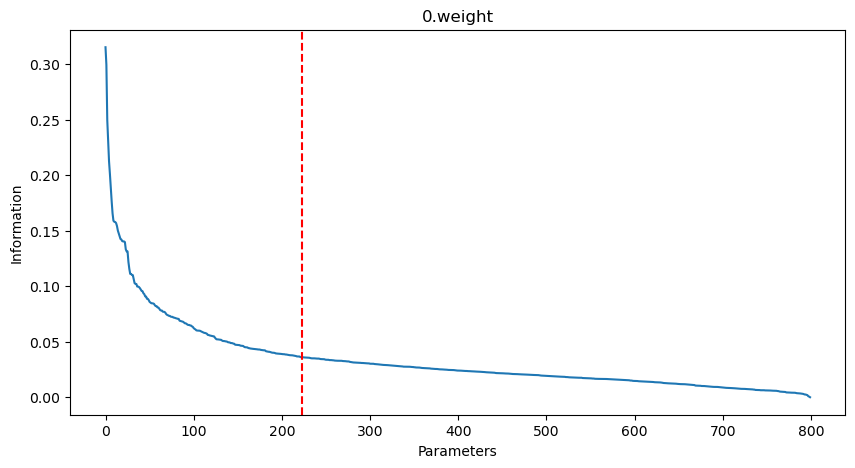

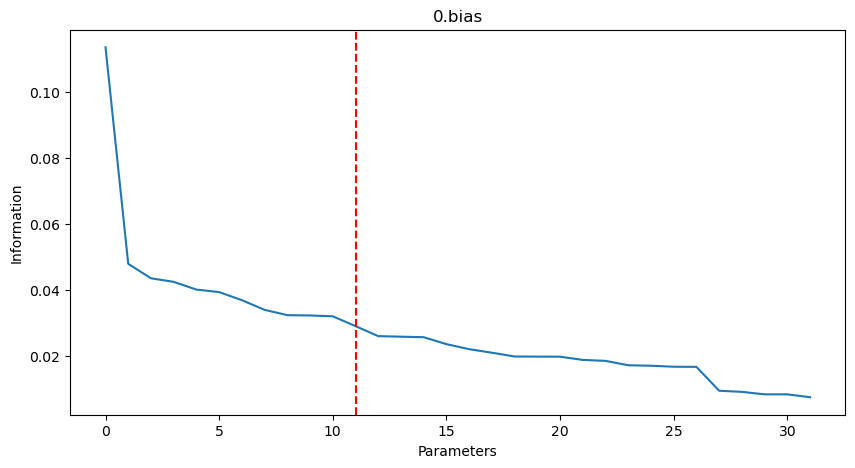

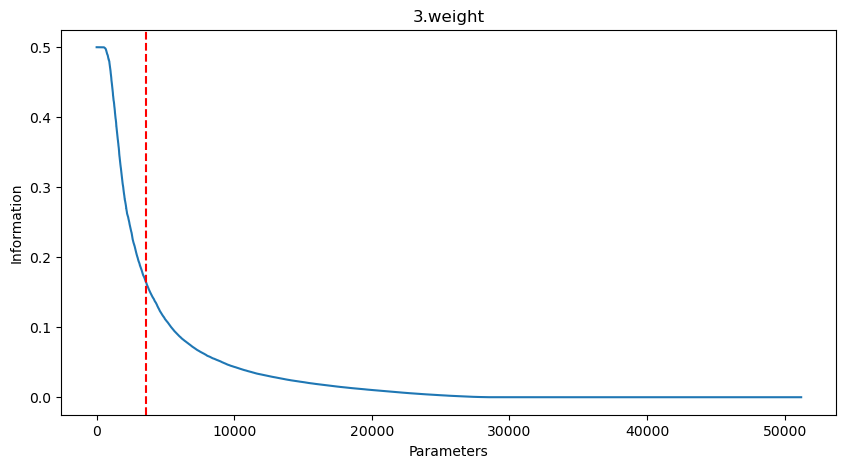

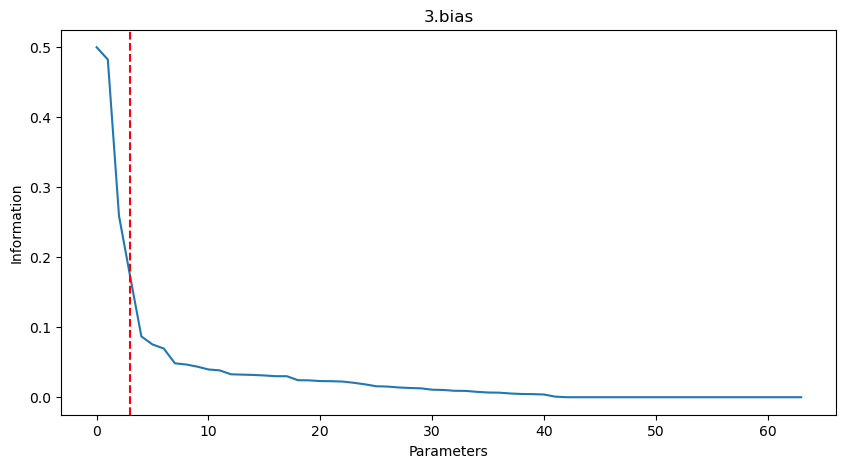

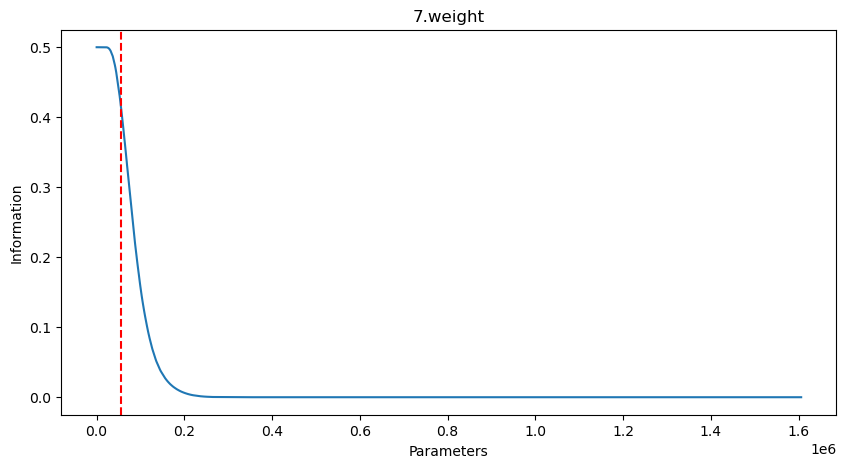

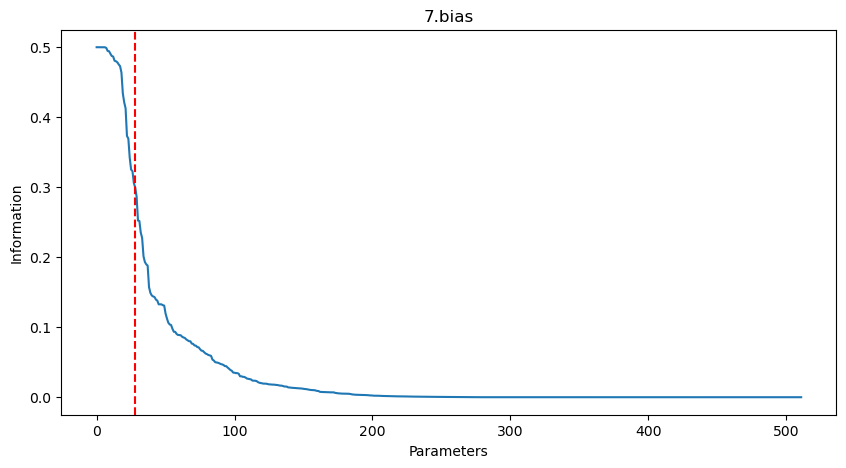

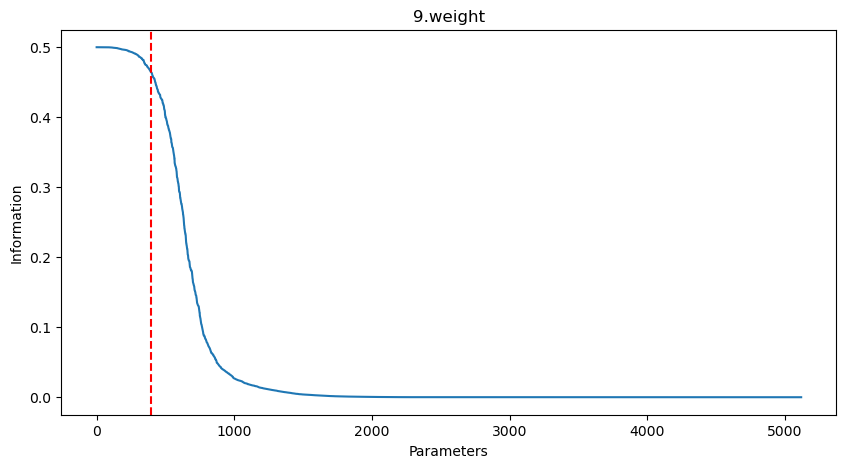

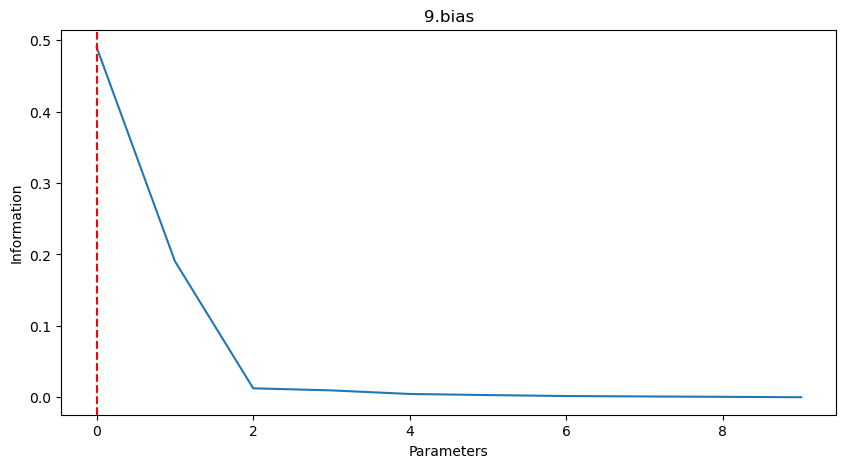

Layer: 0.weight, Parameters: torch.Size([223, 4])
Layer: 0.bias, Parameters: torch.Size([11, 1])
Layer: 3.weight, Parameters: torch.Size([3564, 4])
Layer: 3.bias, Parameters: torch.Size([3, 1])
Layer: 7.weight, Parameters: torch.Size([54891, 2])
Layer: 7.bias, Parameters: torch.Size([28, 1])
Layer: 9.weight, Parameters: torch.Size([398, 2])
Layer: 9.bias, Parameters: torch.Size([0, 1])


<All keys matched successfully>

In [ ]:
from fisherunlearn import find_informative_params, reset_parameters, plot_information_parameters_tradeoff

info=informations[target_client]

whitelist = []
for name in info.keys():
    if "weight" in name:
        whitelist.append(name)

plot_information_parameters_tradeoff(info, method='information')
plot_information_parameters_tradeoff(info, method='parameters')
informative_params = find_informative_params(info, method='information', percentage=60, graph=True)

for name, params in informative_params.items():
    print(f"Layer: {name}, Parameters: {params.shape}")  # Print first 5 values for brevity
    

resetted_model = FLNet()

resetted_model.load_state_dict(reset_parameters(model, informative_params), strict=False)


In [ ]:
from fisherunlearn import UnlearnNet
for name in informative_params.keys():
    print(f"Layer: {name}, number of parameters: {len(informative_params[name])}")
retrainer = UnlearnNet(model, informative_params)
loss_fn = nn.CrossEntropyLoss()
retrainer = trainer(retrainer, loss_fn, benchmark_dataloaders, epochs=1)
retrained_model = FLNet()
retrained_model.load_state_dict(retrainer.get_retrained_params(), strict=False)

Layer: 0.weight, number of parameters: 223
Layer: 0.bias, number of parameters: 11
Layer: 3.weight, number of parameters: 3564
Layer: 3.bias, number of parameters: 3
Layer: 7.weight, number of parameters: 54891
Layer: 7.bias, number of parameters: 28
Layer: 9.weight, number of parameters: 398
Layer: 9.bias, number of parameters: 0
cuda
Epoch 1/1, Loss: 0.0000


<All keys matched successfully>

In [ ]:
print("Confusion matrix benchmark:")
acc, conf_mat = validate(model_benchmark, classes_dataloaders, num_classes)
plot_confusion_matrix(conf_mat)
print("Confusion matrix trained:")
acc, conf_mat = validate(model, classes_dataloaders, num_classes)
plot_confusion_matrix(conf_mat)
print("Confusion matrix resetted:")
acc, conf_mat = validate(resetted_model, classes_dataloaders, num_classes)
plot_confusion_matrix(conf_mat)
print("Confusion matrix retrained:")
acc, conf_mat = validate(retrained_model, classes_dataloaders, num_classes)
plot_confusion_matrix(conf_mat)

Confusion matrix benchmark:


,0,1,2,3,4,5,6,7,8,9
0,5918,0,1,0,0,0,0,0,0,4
1,1,6731,2,0,1,0,0,0,0,7
2,0,1,5952,1,2,0,0,0,1,1
3,1,0,3,6120,0,0,0,0,0,7
4,1,3,1,0,5781,0,0,0,0,56
5,17,15,5,2597,12,0,26,0,316,2433
6,71,24,2,1,22,0,5644,0,143,11
7,13,46,146,182,14,0,0,4594,31,1239
8,12,24,9,61,4,0,2,0,4493,1246
9,0,0,0,1,0,0,0,0,0,5948


Confusion matrix trained:


,0,1,2,3,4,5,6,7,8,9
0,5921,0,0,0,0,0,0,0,0,2
1,2,6733,2,0,0,0,0,0,0,5
2,1,1,5951,1,0,0,0,0,0,4
3,0,0,0,6126,0,0,0,0,0,5
4,0,0,1,0,5747,0,0,0,0,94
5,15,7,3,483,3,4406,11,0,103,390
6,351,28,28,4,75,1,5148,0,275,8
7,7,81,133,144,4,0,0,2634,7,3255
8,22,4,79,83,5,0,1,0,2910,2747
9,0,0,0,0,0,0,0,0,0,5949


Confusion matrix resetted:


,0,1,2,3,4,5,6,7,8,9
0,5879,0,18,4,1,0,0,0,1,20
1,1,6670,42,0,10,1,0,0,0,18
2,0,2,5937,9,1,1,0,0,0,8
3,2,1,45,6074,1,0,0,0,0,8
4,0,2,2,1,5630,0,0,2,0,205
5,10,4,3,1048,4,3965,46,0,60,281
6,185,63,46,12,316,7,4783,0,472,34
7,2,94,345,52,13,8,0,1433,3,4315
8,18,12,113,272,14,94,0,0,2032,3296
9,1,0,1,10,2,0,0,0,0,5935


Confusion matrix retrained:


KeyboardInterrupt: 

KeyboardInterrupt: 

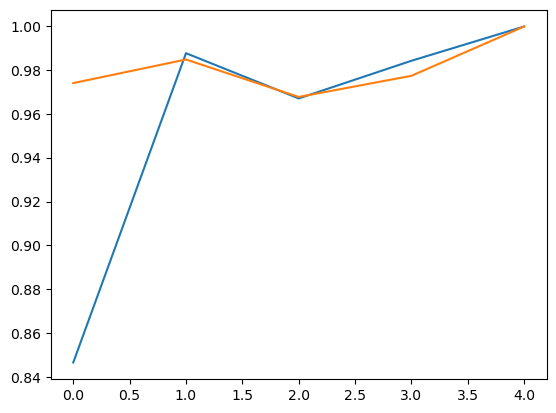

In [ ]:

plt.plot(compute_dataloaders_accuracy(model_benchmark, client_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, client_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, client_dataloaders), label='Resetted')
plt.plot(compute_dataloaders_accuracy(retrained_model, client_dataloaders), label='Retrained')
plt.legend()
plt.xlabel('Client')
plt.xticks(np.arange(0, 5, 1))
plt.ylabel('Accuracy')
plt.title('Client Accuracies on training dataset')
plt.show()

In [ ]:

plt.plot(compute_dataloaders_accuracy(model_benchmark, classes_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, classes_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, classes_dataloaders), label='Resetted')
plt.plot(compute_dataloaders_accuracy(retrained_model, classes_dataloaders), label='Retrained')
plt.legend()
plt.xlabel('Class')
plt.xticks(np.arange(0, 10, 1))
plt.ylabel('Accuracy')
plt.title('Classes Accuracies on complete dataset (Train=True)')
plt.show()


In [ ]:
print("Benchmark model test accuracy:")
print(compute_accuracy(model_benchmark, test_dataloader))
print("Trained model test accuracy:")
print(compute_accuracy(model, test_dataloader))
print("Resetted model test accuracy:")
print(compute_accuracy(resetted_model, test_dataloader))
print("Benchmark model target client accuracy:")
print(compute_accuracy(model_benchmark, target_dataloader))
print("Trained model target client accuracy:")
print(compute_accuracy(model, target_dataloader))
print("Resetted model target client accuracy:")
print(compute_accuracy(resetted_model, target_dataloader))

Calculating benchmark accuracies (retrained_model)...
  Benchmark Global Test Accuracy: 0.9590
  Benchmark Target Client Accuracy: 0.8983


Processing Percentages:   0%|          | 0/11 [00:00<?, ?it/s]


Evaluating unlearning for different parameter percentages...

--- Processing Percentage: 0% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.9778
  Reset-Only Target Client Accuracy: 0.9752
  Delta Test Acc (Reset - Benchmark): 0.0188
  Delta Target Acc (Reset - Benchmark): 0.0769
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0001


Processing Percentages:   9%|▉         | 1/11 [00:14<02:20, 14.05s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9685
  Retrained-from-Reset Target Client Accuracy: 0.9614
  Delta Test Acc (Retrained - Benchmark): 0.0095
  Delta Target Acc (Retrained - Benchmark): 0.0631

--- Processing Percentage: 10% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.9263
  Reset-Only Target Client Accuracy: 0.8118
  Delta Test Acc (Reset - Benchmark): -0.0327
  Delta Target Acc (Reset - Benchmark): -0.0865
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0000


Processing Percentages:  18%|█▊        | 2/11 [00:27<02:05, 13.97s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9755
  Retrained-from-Reset Target Client Accuracy: 0.9715
  Delta Test Acc (Retrained - Benchmark): 0.0165
  Delta Target Acc (Retrained - Benchmark): 0.0732

--- Processing Percentage: 20% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.9258
  Reset-Only Target Client Accuracy: 0.8095
  Delta Test Acc (Reset - Benchmark): -0.0332
  Delta Target Acc (Reset - Benchmark): -0.0888
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0006


Processing Percentages:  27%|██▋       | 3/11 [00:41<01:51, 13.90s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9788
  Retrained-from-Reset Target Client Accuracy: 0.9723
  Delta Test Acc (Retrained - Benchmark): 0.0198
  Delta Target Acc (Retrained - Benchmark): 0.0740

--- Processing Percentage: 30% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.9092
  Reset-Only Target Client Accuracy: 0.7338
  Delta Test Acc (Reset - Benchmark): -0.0498
  Delta Target Acc (Reset - Benchmark): -0.1645
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0064


Processing Percentages:  36%|███▋      | 4/11 [00:55<01:37, 13.87s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9787
  Retrained-from-Reset Target Client Accuracy: 0.9686
  Delta Test Acc (Retrained - Benchmark): 0.0197
  Delta Target Acc (Retrained - Benchmark): 0.0703

--- Processing Percentage: 40% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.8488
  Reset-Only Target Client Accuracy: 0.5105
  Delta Test Acc (Reset - Benchmark): -0.1102
  Delta Target Acc (Reset - Benchmark): -0.3878
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0016


Processing Percentages:  45%|████▌     | 5/11 [01:09<01:23, 13.90s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9613
  Retrained-from-Reset Target Client Accuracy: 0.9509
  Delta Test Acc (Retrained - Benchmark): 0.0023
  Delta Target Acc (Retrained - Benchmark): 0.0526

--- Processing Percentage: 50% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.7902
  Reset-Only Target Client Accuracy: 0.4667
  Delta Test Acc (Reset - Benchmark): -0.1688
  Delta Target Acc (Reset - Benchmark): -0.4316
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0000


Processing Percentages:  55%|█████▍    | 6/11 [01:27<01:16, 15.28s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9682
  Retrained-from-Reset Target Client Accuracy: 0.9638
  Delta Test Acc (Retrained - Benchmark): 0.0092
  Delta Target Acc (Retrained - Benchmark): 0.0655

--- Processing Percentage: 60% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.7442
  Reset-Only Target Client Accuracy: 0.4315
  Delta Test Acc (Reset - Benchmark): -0.2148
  Delta Target Acc (Reset - Benchmark): -0.4668
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0015


Processing Percentages:  64%|██████▎   | 7/11 [01:44<01:03, 15.87s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9631
  Retrained-from-Reset Target Client Accuracy: 0.9278
  Delta Test Acc (Retrained - Benchmark): 0.0041
  Delta Target Acc (Retrained - Benchmark): 0.0295

--- Processing Percentage: 70% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.6752
  Reset-Only Target Client Accuracy: 0.3637
  Delta Test Acc (Reset - Benchmark): -0.2838
  Delta Target Acc (Reset - Benchmark): -0.5346
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0001


Processing Percentages:  73%|███████▎  | 8/11 [01:59<00:46, 15.66s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9728
  Retrained-from-Reset Target Client Accuracy: 0.9439
  Delta Test Acc (Retrained - Benchmark): 0.0138
  Delta Target Acc (Retrained - Benchmark): 0.0456

--- Processing Percentage: 80% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.5892
  Reset-Only Target Client Accuracy: 0.2873
  Delta Test Acc (Reset - Benchmark): -0.3698
  Delta Target Acc (Reset - Benchmark): -0.6110
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0005


Processing Percentages:  82%|████████▏ | 9/11 [02:16<00:31, 15.89s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9504
  Retrained-from-Reset Target Client Accuracy: 0.8757
  Delta Test Acc (Retrained - Benchmark): -0.0086
  Delta Target Acc (Retrained - Benchmark): -0.0226

--- Processing Percentage: 90% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.3092
  Reset-Only Target Client Accuracy: 0.0180
  Delta Test Acc (Reset - Benchmark): -0.6498
  Delta Target Acc (Reset - Benchmark): -0.8803
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 0.0142


Processing Percentages:  91%|█████████ | 10/11 [02:31<00:15, 15.57s/it]

  Retrained-from-Reset Global Test Accuracy: 0.9425
  Retrained-from-Reset Target Client Accuracy: 0.8957
  Delta Test Acc (Retrained - Benchmark): -0.0165
  Delta Target Acc (Retrained - Benchmark): -0.0026

--- Processing Percentage: 100% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.0892
  Reset-Only Target Client Accuracy: 0.0000
  Delta Test Acc (Reset - Benchmark): -0.8698
  Delta Target Acc (Reset - Benchmark): -0.8983
  Retraining from reset for 1 epoch(s)...
cuda
Epoch 1/1, Loss: 1.7921


Processing Percentages: 100%|██████████| 11/11 [02:45<00:00, 15.07s/it]

  Retrained-from-Reset Global Test Accuracy: 0.0980
  Retrained-from-Reset Target Client Accuracy: 0.0426
  Delta Test Acc (Retrained - Benchmark): -0.8610
  Delta Target Acc (Retrained - Benchmark): -0.8557

Plotting results...


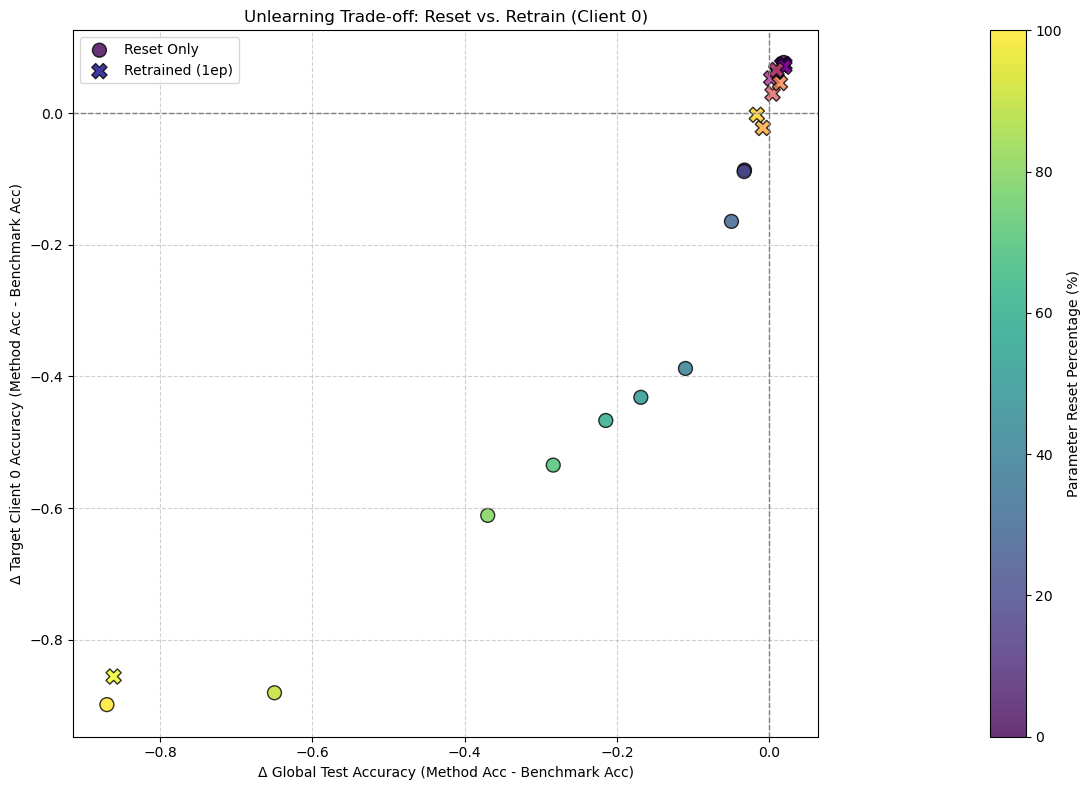


Computed Deltas:
{'delta_test_accuracies_reset': [0.01880000000000004, -0.03269999999999995, -0.03320000000000001, -0.049799999999999955, -0.11019999999999996, -0.16879999999999995, -0.2148, -0.28379999999999994, -0.3698, -0.6497999999999999, -0.8697999999999999], 'delta_target_accuracies_reset': [0.07688373678827143, -0.08651551312649164, -0.08881691101261502, -0.1645073303784521, -0.38782816229116945, -0.4316399590862598, -0.4668428230480737, -0.5346062052505967, -0.6109785202863962, -0.880327309921582, -0.8983123082168428], 'delta_test_accuracies_retrained': [0.009500000000000064, 0.01650000000000007, 0.01980000000000004, 0.01970000000000005, 0.0023000000000000798, 0.009199999999999986, 0.0040999999999999925, 0.013800000000000034, -0.008599999999999941, -0.01649999999999996, -0.861], 'delta_target_accuracies_retrained': [0.06307534947153082, 0.07321854756222301, 0.07398568019093077, 0.07032049096488235, 0.052591203545857446, 0.0654619843163996, 0.02949198772587791, 0.04560177292874

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from typing import Callable, Dict, List, Optional, Any, Union

# Assume these functions are defined elsewhere in your library:
# - compute_accuracy(model, dataloader, device) -> float
# - find_informative_params(info, method, param_percentage, graph) -> List[str]
# - reset_parameters(original_model, params_to_reset) -> Dict[str, torch.Tensor]
# - trainer(model, loss_fn, client_dataloaders, epochs, ...) -> trained_model # Your trainer function

class UnlearningTradeoffPlotter:
    """
    Computes and plots the unlearning trade-off graph.

    Compares the drop in accuracy on a global test set vs. the drop in accuracy
    on the target client's data for various parameter reset percentages. Plots results
    for both the reset-only model and a model retrained after resetting. Deltas
    are calculated relative to a benchmark 'retrained_model'.
    """
    def __init__(
        self,
        # Models & Data
        original_model: torch.nn.Module,
        retrained_model: torch.nn.Module, # Benchmark model (e.g., model_benchmark)
        informations: Dict[Any, Dict[str, torch.Tensor]],
        target_client: Any,
        target_client_dataloader: torch.utils.data.DataLoader,
        global_test_dataloader: torch.utils.data.DataLoader,
        benchmark_dataloaders: List[torch.utils.data.DataLoader], # DataLoaders excluding target_client

        # Core Functions & Model Arch
        model_architecture_fn: Callable[..., torch.nn.Module],
        model_init_args: Dict[str, Any],
        find_informative_params_fn: Callable[..., List[str]],
        reset_parameters_fn: Callable[..., Dict[str, torch.Tensor]],
        compute_accuracy_fn: Callable[..., float],
        trainer_fn: Callable[..., torch.nn.Module], # Your trainer function
        loss_fn_retrain: nn.Module, # Loss function for retraining step

        # Configuration
        epochs_retrain: int = 1, # Epochs for retraining after reset
        device: Optional[Union[str, torch.device]] = None,
        verbose: bool = True
    ):
        """
        Initializes the plotter with models, data, and functions.
        """
        self.original_model = original_model.cpu() # Keep original on CPU
        self.retrained_model = retrained_model
        self.informations = informations
        self.target_client = target_client
        self.target_client_dataloader = target_client_dataloader
        self.global_test_dataloader = global_test_dataloader
        self.benchmark_dataloaders = benchmark_dataloaders # Data for retraining

        self.model_architecture_fn = model_architecture_fn
        self.model_init_args = model_init_args
        self.find_informative_params_fn = find_informative_params_fn
        self.reset_parameters_fn = reset_parameters_fn
        self.compute_accuracy_fn = compute_accuracy_fn
        self.trainer_fn = trainer_fn # Store trainer function
        self.loss_fn_retrain = loss_fn_retrain # Store loss for retraining
        self.epochs_retrain = epochs_retrain # Store epochs for retraining

        self.verbose = verbose

        if device is None:
            self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self._device = torch.device(device)

        # Results storage
        self.delta_test_accuracies_reset: List[float] = []
        self.delta_target_accuracies_reset: List[float] = []
        self.delta_test_accuracies_retrained: List[float] = []
        self.delta_target_accuracies_retrained: List[float] = []
        self.param_percentages_tested: Optional[np.ndarray] = None

        # Calculate benchmark accuracies once
        self._calculate_benchmark_accuracies()

    def _calculate_benchmark_accuracies(self):
        """Computes and stores benchmark accuracies."""
        if self.verbose: print("Calculating benchmark accuracies (retrained_model)...")
        self.retrained_model.to(self._device)
        self.retrained_test_acc = self.compute_accuracy_fn(
            self.retrained_model, self.global_test_dataloader, device=self._device
        )
        self.retrained_target_acc = self.compute_accuracy_fn(
            self.retrained_model, self.target_client_dataloader, device=self._device
        )
        # Optional: Move back to CPU
        # self.retrained_model.cpu()
        if self.verbose:
            print(f"  Benchmark Global Test Accuracy: {self.retrained_test_acc:.4f}")
            print(f"  Benchmark Target Client Accuracy: {self.retrained_target_acc:.4f}")

    # In class UnlearningTradeoffPlotter:

    def compute_deltas(
        self,
        param_percentages: Optional[Union[List[float], np.ndarray]] = None
    ) -> Dict[str, List[float]]:
        """
        Computes the accuracy deltas (Unlearned Acc - Benchmark Acc) for the
        specified percentages for both reset-only and retrained-from-reset models.

        Args:
            param_percentages: List/array of percentages (0-100). Defaults to [0, 10,..., 100].

        Returns:
            Dictionary containing the computed deltas and percentages.
        """
        if param_percentages is None:
            self.param_percentages_tested = np.linspace(0, 100, 11).astype(int)
        else:
            self.param_percentages_tested = np.array(param_percentages)

        # Reset results lists
        self.delta_test_accuracies_reset = []
        self.delta_target_accuracies_reset = []
        self.delta_test_accuracies_retrained = []
        self.delta_target_accuracies_retrained = []

        try:
            info = self.informations[self.target_client]
        except KeyError:
            raise ValueError(f"Target client '{self.target_client}' not found in informations dict.")

        iterator = tqdm(self.param_percentages_tested, desc="Processing Percentages") if self.verbose else self.param_percentages_tested
        if self.verbose: print("\nEvaluating unlearning for different parameter percentages...")

        for perc in iterator:
            if self.verbose: print(f"\n--- Processing Percentage: {perc}% ---")

            resetted_model = None
            retrained_from_reset_model = None

            try:
                # --- Reset Step ---
                informative_params = self.find_informative_params_fn(
                    info, method='information', percentage=perc, graph=False
                )
                if self.verbose: print(f"  Found {len(informative_params)} informative parameter names.")

                resetted_model = self.model_architecture_fn(**self.model_init_args)
                resetted_state_dict = self.reset_parameters_fn(self.original_model, informative_params)
                resetted_model.load_state_dict(resetted_state_dict, strict=True)
                resetted_model.to(self._device)

                # Evaluate Reset-Only Model
                reset_test_acc = self.compute_accuracy_fn(resetted_model, self.global_test_dataloader, device=self._device)
                reset_target_acc = self.compute_accuracy_fn(resetted_model, self.target_client_dataloader, device=self._device)
                if self.verbose:
                    print(f"  Reset-Only Global Test Accuracy: {reset_test_acc:.4f}")
                    print(f"  Reset-Only Target Client Accuracy: {reset_target_acc:.4f}")

                # --- Calculate Deltas for Reset-Only (Unlearned - Benchmark) ---
                delta_test_reset = reset_test_acc - self.retrained_test_acc      # Swapped
                delta_target_reset = reset_target_acc - self.retrained_target_acc  # Swapped
                self.delta_test_accuracies_reset.append(delta_test_reset)
                self.delta_target_accuracies_reset.append(delta_target_reset)
                if self.verbose:
                    # Updated print statement description
                    print(f"  Delta Test Acc (Reset - Benchmark): {delta_test_reset:.4f}")
                    print(f"  Delta Target Acc (Reset - Benchmark): {delta_target_reset:.4f}")

                # --- Retrain Step ---
                if self.verbose: print(f"  Retraining from reset for {self.epochs_retrain} epoch(s)...")

                retrained_from_reset_model = self.trainer_fn(
                    model=resetted_model,
                    loss_fn=self.loss_fn_retrain,
                    client_dataloaders=self.benchmark_dataloaders,
                    epochs=self.epochs_retrain
                )
                retrained_from_reset_model.to(self._device)


                # Evaluate Retrained-from-Reset Model
                retrained_r_test_acc = self.compute_accuracy_fn(retrained_from_reset_model, self.global_test_dataloader, device=self._device)
                retrained_r_target_acc = self.compute_accuracy_fn(retrained_from_reset_model, self.target_client_dataloader, device=self._device)
                if self.verbose:
                    print(f"  Retrained-from-Reset Global Test Accuracy: {retrained_r_test_acc:.4f}")
                    print(f"  Retrained-from-Reset Target Client Accuracy: {retrained_r_target_acc:.4f}")

                # --- Calculate Deltas for Retrained-from-Reset (Unlearned - Benchmark) ---
                delta_test_retrained = retrained_r_test_acc - self.retrained_test_acc      # Swapped
                delta_target_retrained = retrained_r_target_acc - self.retrained_target_acc  # Swapped
                self.delta_test_accuracies_retrained.append(delta_test_retrained)
                self.delta_target_accuracies_retrained.append(delta_target_retrained)
                if self.verbose:
                     # Updated print statement description
                    print(f"  Delta Test Acc (Retrained - Benchmark): {delta_test_retrained:.4f}")
                    print(f"  Delta Target Acc (Retrained - Benchmark): {delta_target_retrained:.4f}")

            except Exception as e:
                print(f"\nERROR processing percentage {perc}: {e}")
                self.delta_test_accuracies_reset.append(float('nan'))
                self.delta_target_accuracies_reset.append(float('nan'))
                self.delta_test_accuracies_retrained.append(float('nan'))
                self.delta_target_accuracies_retrained.append(float('nan'))

            finally:
                final_resetted_ref = resetted_model
                final_retrained_ref = retrained_from_reset_model
                if final_retrained_ref is not None and final_resetted_ref is not None and final_retrained_ref is not final_resetted_ref:
                    del retrained_from_reset_model
                    final_retrained_ref = None
                if final_resetted_ref is not None:
                    del resetted_model
                    final_resetted_ref = None
                if self._device.type == 'cuda':
                   torch.cuda.empty_cache()


        results = {
            'delta_test_accuracies_reset': self.delta_test_accuracies_reset,
            'delta_target_accuracies_reset': self.delta_target_accuracies_reset,
            'delta_test_accuracies_retrained': self.delta_test_accuracies_retrained,
            'delta_target_accuracies_retrained': self.delta_target_accuracies_retrained,
            'param_percentages': list(self.param_percentages_tested)
        }
        return results

    def plot(
        self,
        plot_kwargs_reset: Optional[Dict[str, Any]] = None,
        plot_kwargs_retrained: Optional[Dict[str, Any]] = None,
        show_plot: bool = True,
        title_suffix: str = ""
    ):
        """
        Generates the trade-off plot showing both reset-only and retrained results.

        Args:
            plot_kwargs_reset: Dict of keyword arguments for reset-only plt.scatter.
            plot_kwargs_retrained: Dict of keyword arguments for retrained plt.scatter.
            show_plot: If True, displays the plot using plt.show().
            title_suffix: Optional string to append to the plot title.
        """
        if not self.delta_test_accuracies_reset or self.param_percentages_tested is None:
            raise RuntimeError("Deltas have not been computed. Call compute_deltas() first.")

        if plot_kwargs_reset is None: plot_kwargs_reset = {}
        if plot_kwargs_retrained is None: plot_kwargs_retrained = {}

        if self.verbose: print("\nPlotting results...")
        plt.figure(figsize=(11, 8))

        # --- Plot Reset-Only Results ---
        scatter_defaults_reset = {
            'c': self.param_percentages_tested, 'cmap': 'viridis', 's': 100,
            'alpha': 0.8, 'edgecolors': 'k', 'marker': 'o', 'label': 'Reset Only'
        }
        scatter_defaults_reset.update(plot_kwargs_reset)
        scatter1 = plt.scatter(
            self.delta_test_accuracies_reset,
            self.delta_target_accuracies_reset,
            **scatter_defaults_reset
        )

        # --- Plot Retrained-from-Reset Results ---
        scatter_defaults_retrained = {
             'c': self.param_percentages_tested, 'cmap': 'plasma', 's': 120,
             'alpha': 0.8, 'edgecolors': 'k', 'marker': 'X', 'label': f'Retrained ({self.epochs_retrain}ep)'
        }
        scatter_defaults_retrained.update(plot_kwargs_retrained)
        scatter2 = plt.scatter(
            self.delta_test_accuracies_retrained,
            self.delta_target_accuracies_retrained,
            **scatter_defaults_retrained
        )

        # Add annotations
        """ for i, perc in enumerate(self.param_percentages_tested):
             perc_label = f"{int(perc) if perc == int(perc) else perc:.1f}%"
             plt.annotate(perc_label,
                          (self.delta_test_accuracies_reset[i], self.delta_target_accuracies_reset[i]),
                          textcoords="offset points", xytext=(-10, 10),
                          ha='center', fontsize=9, color='darkgreen')
             plt.annotate(perc_label,
                          (self.delta_test_accuracies_retrained[i], self.delta_target_accuracies_retrained[i]),
                          textcoords="offset points", xytext=(10, -15),
                          ha='center', fontsize=9, color='darkred')
 """
        plt.colorbar(scatter1, label='Parameter Reset Percentage (%)', location='right', anchor=(1.2, 0.5))

        # --- UPDATED AXIS LABELS ---
        plt.xlabel('Δ Global Test Accuracy (Method Acc - Benchmark Acc)')
        plt.ylabel(f'Δ Target Client {self.target_client} Accuracy (Method Acc - Benchmark Acc)')
        plt.title(f'Unlearning Trade-off: Reset vs. Retrain (Client {self.target_client}){title_suffix}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axhline(0, color='grey', lw=1.0, linestyle='--')
        plt.axvline(0, color='grey', lw=1.0, linestyle='--')
        plt.legend(loc='best')
        plt.tight_layout()

        if show_plot:
            plt.show()

    def run(
        self,
        param_percentages: Optional[Union[List[float], np.ndarray]] = None,
        plot_kwargs_reset: Optional[Dict[str, Any]] = None,
        plot_kwargs_retrained: Optional[Dict[str, Any]] = None,
        show_plot: bool = True,
        title_suffix: str = ""
    ) -> Dict[str, List[float]]:
        """
        Runs both delta computation and plotting for reset and retrained models.

        Args:
            (See compute_deltas and plot methods for argument details)

        Returns:
            Dictionary containing the computed deltas and percentages.
        """
        results = self.compute_deltas(param_percentages)
        self.plot(
            plot_kwargs_reset=plot_kwargs_reset,
            plot_kwargs_retrained=plot_kwargs_retrained,
            show_plot=show_plot,
            title_suffix=title_suffix
        )
        return results


loss_retrain = nn.CrossEntropyLoss() # Define the loss for the retraining step

plotter = UnlearningTradeoffPlotter(
    # Models & Data
    original_model=model,
    retrained_model=model_benchmark, # Benchmark model
    informations=informations,
    target_client=target_client,
    target_client_dataloader=target_dataloader,
    global_test_dataloader=test_dataloader,
    benchmark_dataloaders=benchmark_dataloaders, # DataLoaders excluding target_client

    # Core Functions & Model Arch
    model_architecture_fn=FLNet,
    model_init_args={},
    find_informative_params_fn=find_informative_params,
    reset_parameters_fn=reset_parameters,
    compute_accuracy_fn=compute_accuracy,
    trainer_fn=trainer, # Your trainer function
    loss_fn_retrain=loss_retrain, # Loss for retraining step

    # Configuration
    epochs_retrain=1, # Epochs for retraining after reset
    device=None,
    verbose=True
)

# Run computation and plotting
results = plotter.run(param_percentages=np.linspace(0, 100, 11).astype(int)) 

print("\nComputed Deltas:")
print(results)